# Import packages

In [1]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

import matplotlib.dates as mdates

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [2]:
import sklearn as sk
import statsmodels.api as sm

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import ARMA


from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

import copy

# Custom functions

In [3]:
def diff_for_stationarity(df_input,cols,threshold):
    
    """Checks the series for stationarity then difference it until it is stationary
    (with the given threshold)"""
    
    df = copy.deepcopy(df_input)
    
    
    # Get length of DF
    n = len(df)
    
    # Loop over columns of interest
    for col in cols:
        stationarity = False
        series = list(df[col].astype(float))
        linear_diff = False
        
        try:
        
            counter = 0



            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                else:
                    # Difference the series
                    #series = [np.log(series[i]/series[i-1]) for i in range(1,n-counter)]
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
                    
        except:
            
            counter = 0
            stationarity = False
            series = list(df[col].astype(float))
            linear_diff = True

            while not stationarity:

                #print(counter)

                # Run ADF test
                adf_test = adfuller(series)
                pval = adf_test[1]

                if pval < threshold:
                    stationarity = True

                elif counter>1:
                    stationarity = True
                    series = list(df[col].astype(float))
                else:
                    # Difference the series
                    series = [series[i]-series[i-1] for i in range(1,n-counter)]

                    counter += 1
        
        # Create final series and assign it back to the dataframe
        final_series = [None]*counter + series
        df[col] = final_series
        
        if linear_diff:
            type_diff = "linear difference"
        else:
            type_diff = "linear difference"
        
        print("Variable: {} is {}-order integrated ({})!".format(col,counter,type_diff))
        
        
    return df

# Import data

In [4]:
df = pd.read_csv('../Data/merged_dataset.csv')

df.set_index('Date',inplace=True)

print(df.head())

            carbon_price  oil_price  gas_price  stock_market_index_level
Date                                                                    
2017-01-02          6.12        NaN       3.71                       NaN
2017-01-03          5.43      52.36       3.41               3315.020020
2017-01-04          5.72      53.26       3.42               3317.520020
2017-01-05          5.29      53.77       3.42               3316.469971
2017-01-06          5.50      53.98       3.38               3321.169922


# EDA

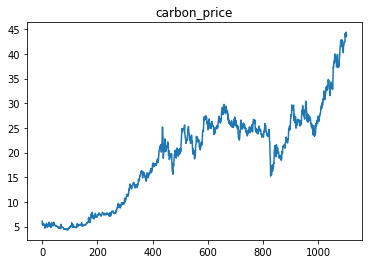

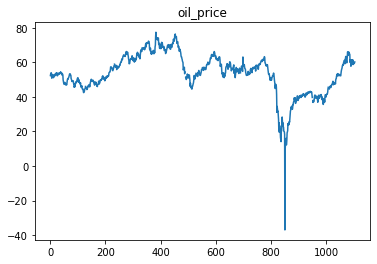

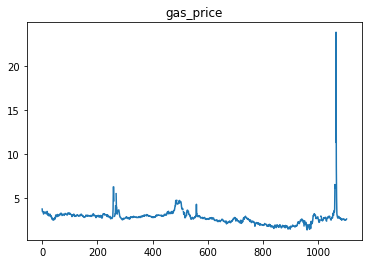

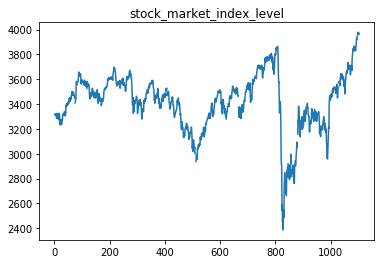

In [5]:
for col in df.columns:
    plt.plot(np.asarray(df[col]))
    plt.title("{}".format(col))
    #plt.plot(df[col])
    plt.show()

# Data preprocessing

## Handle missing values

In [6]:
df = df.fillna(method='bfill')

## Stationarity checks

In [9]:
# Parameters
stacioner_threshold = 0.01
arno_cols = df.columns
current_df = df

# Check for stationarity
df_stationer = diff_for_stationarity(df_input=current_df,cols=arno_cols,threshold=stacioner_threshold)

Variable: carbon_price is 1-order integrated (linear difference)!
Variable: oil_price is 1-order integrated (linear difference)!
Variable: gas_price is 0-order integrated (linear difference)!
Variable: stock_market_index_level is 1-order integrated (linear difference)!


In [10]:
df_stationer

,carbon_price,oil_price,gas_price,stock_market_index_level
Date,,,,
2017-01-02,NaN,NaN,3.71,NaN
2017-01-03,-0.69,0.00,3.41,0.000000
2017-01-04,0.29,0.90,3.42,2.500000
2017-01-05,-0.43,0.51,3.42,-1.050049
2017-01-06,0.21,0.21,3.38,4.699951
...,...,...,...,...
2021-04-07,-0.38,0.43,2.43,-13.649902
2021-04-08,-0.38,-0.16,2.47,21.060058
2021-04-09,0.18,-0.32,2.48,1.010010


In [11]:
# Drop first row after differencing the series
df_stationer = df_stationer.dropna()

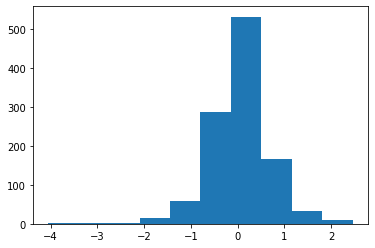

In [12]:
plt.hist(df_stationer.carbon_price)
plt.show()

# Modelling

In [13]:
# Create train-test sets
n = len(df_stationer)
testsize = 0.2

test_obs = int(n*testsize)
df_train, df_test = df_stationer[0:-test_obs], df_stationer[-test_obs:]

# Check size
print(df_train.shape)
print(df_test.shape)

# Be careful with time leakage!

(883, 4)
(220, 4)


## Random forest

In [15]:
X_train = df_train.shift(1).iloc[1:,:].values

y_train = df_train['carbon_price'].iloc[1:]

X_test = df_test.shift(1).iloc[1:,:].values

y_test = df_test['carbon_price'].iloc[1:]

In [16]:
X_train

array([[-6.90000000e-01,  0.00000000e+00,  3.41000000e+00,
         0.00000000e+00],
       [ 2.90000000e-01,  9.00000000e-01,  3.42000000e+00,
         2.50000000e+00],
       [-4.30000000e-01,  5.10000000e-01,  3.42000000e+00,
        -1.05004900e+00],
       ...,
       [-4.30000000e-01, -8.00000000e-02,  1.59000000e+00,
         1.08820069e+02],
       [ 1.10000000e+00,  1.39000000e+00,  1.58000000e+00,
         0.00000000e+00],
       [ 1.00000000e-01,  4.50000000e-01,  1.84000000e+00,
         1.10570068e+02]])

In [17]:
y_train

Date
2017-01-04    0.29
2017-01-05   -0.43
2017-01-06    0.21
2017-01-09   -0.23
2017-01-10    0.24
              ... 
2020-05-29    0.14
2020-06-01   -0.43
2020-06-02    1.10
2020-06-03    0.10
2020-06-04    0.04
Name: carbon_price, Length: 882, dtype: float64

### Gridsearch

In [19]:
rf = RandomForestRegressor(criterion="mse", random_state=0)

# Set parameters for gridsearch
rf_parameters = {'max_depth':[5,10,20,40],
             'max_features':[1,2,3,4],
            'n_estimators':[80,100,120]}

# Run gridsearch
rf_grid = GridSearchCV(rf, rf_parameters, n_jobs=3, 
                   cv=5,
                   scoring='neg_mean_squared_error',
                   verbose=2, refit=True)

# Fit the model
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    5.3s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   18.6s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:   29.8s finished
/Users/MacBook/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=3,
             param_grid={'max_depth': [5, 10, 20, 40],
       

In [24]:
# Inspect the best estimator
rf_grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=80,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [20]:
# Predict with the model
rf_y_pred = rf_grid.predict(X_test)

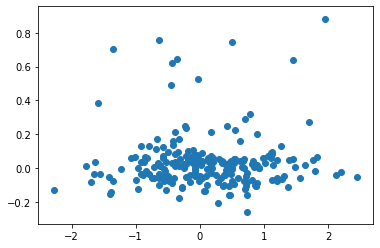

In [21]:
# Compare prediction and actual in the test set
plt.scatter(y_test,rf_y_pred)
plt.show()

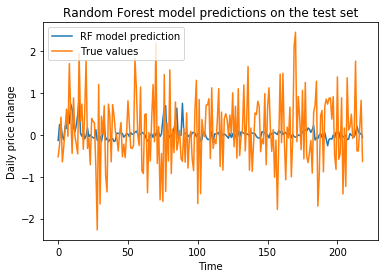

In [22]:
# Compare prediction and actual in the test set
plt.plot(np.asarray(rf_y_pred),label='RF model prediction')
plt.plot(np.asarray(y_test),label='True values')
plt.xlabel('Time')
plt.ylabel('Daily price change')
#plt.yscale('log')
plt.title('Random Forest model predictions on the test set')
plt.legend(loc='upper left')
plt.savefig('../Outputs/daily_pred_rf_with_explanatory_vars.pdf')
plt.show()

In [23]:
mean_squared_error(rf_y_pred,y_test)

0.7009730467330277